# NYS_03_create_patches_v2

In [5]:
from pathlib import Path
import os
workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/")
print(workdir)
os.chdir(workdir)
current_working_dir = Path.cwd()
print(f"Current working directory is now: {current_working_dir}")

/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL
Current working directory is now: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL


In [6]:
import rasterio
import geopandas as gpd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import json

In [7]:
# === Testing Args ===
args = ["Data/NY_hucs/NY_Cluster_Zones_250_NAomit.gpkg",
        208,
        "%",
        "Data/TerrainProcessed/HUC_DEMs/",
        "Data/Training_Data/Wetland_Polygons_For_DL/",
        "Data/NAIP/HUC_NAIP_Processed/",
        "Data/CHMs/HUC_CHMs/",
        "Data/TerrainProcessed/HUC_TerrainMetrics/"]

In [8]:
# === Cluster Import ===
aoi_hucs = gpd.read_file(args[0], where=f"cluster = '{args[1]}' AND huc12 LIKE '{args[2]}'")
aoi_hucs

,name,huc12,cluster,tnmid,geometry
0,Middle Fall Creek,041402011002,208,{D47456E4-B7C7-4E4C-9C05-EFD2CF73CE8F},"MULTIPOLYGON (((394529.328 4712339.381, 394535..."
1,Egypt Creek-Virgil Creek,041402011004,208,{4E9FF2F8-064C-4E2B-9E27-42C07918E428},"MULTIPOLYGON (((397327.071 4707326.245, 397318..."
2,Lower Cayuga Inlet,041402011010,208,{FFF0164F-9ACD-4878-B005-6E378A925887},"MULTIPOLYGON (((373972.985 4698273.813, 373934..."
3,Headwaters Sixmile Creek,041402011009,208,{715C20CA-8C6B-445B-BE49-8A493BA6951F},"MULTIPOLYGON (((386909.737 4694753.004, 387034..."
4,Middle Cayuga Inlet,041402011008,208,{2FE38840-4B6B-403A-81D5-5682831B2CD6},"MULTIPOLYGON (((379295.911 4692999.617, 379348..."
5,Headwaters Owasco Inlet,041402011301,208,{85EFCC71-3C0B-449A-B376-FD3C48DCC0D4},"MULTIPOLYGON (((385460.553 4724264.235, 385508..."
6,Lower Fall Creek,041402011005,208,{E8C17529-73DD-4D19-AE85-541848309EB2},"MULTIPOLYGON (((390059.463 4703731.281, 390099..."
7,Salmon Creek,041402011102,208,{2CEDE39B-6473-4D10-8345-FE779207439C},"MULTIPOLYGON (((377329.857 4722056.192, 377365..."
8,Willow Creek-Cayuga Lake,041402011103,208,{F445F39F-E97D-4708-9C16-CB0BD6594350},"MULTIPOLYGON (((370013.1 4708400.592, 370027.9..."


In [13]:
# === CONFIGURATION ===

patch_size = 128
max_offset = 32  # Random offset from centroid (pixels) to add variety
background_patches = 120  # Number of random background patches to include
val_split = 0.2
random_seed = 42

output_dir = Path("Data/Patches_v2")

In [14]:
# === RASTER INPUT CONFIGURATION ===
# Define input rasters and how to handle their bands
# - "path_pattern": glob pattern with {huc} placeholder
# - "bands": list of band names, or None to read from raster descriptions
raster_inputs = [
    {
        "name": "naip",
        "path_pattern": "Data/NAIP/HUC_NAIP_Processed/*{huc}*.tif",
        "bands": None,  # Read from raster descriptions (r, g, b, nir, ndvi, ndwi)
    },
    {
        "name": "dem",
        "path_pattern": "Data/TerrainProcessed/HUC_DEMs/*{huc}.tif",
        "bands": ["dem"],  # Single band, manually named
    },
    {
        "name": "chm",
        "path_pattern": "Data/CHMs/HUC_CHMs/*{huc}*.tif",
        "bands": ["chm"],  # Single band, manually named
    },
    {
        "name": "terrain",
        "path_pattern": "Data/TerrainProcessed/HUC_TerrainMetrics/*{huc}*5m.tif",
        "bands": None,  # Read from descriptions (slope_5m, TPI_5m, Geomorph_5m)
    },
]

# === NORMALIZATION RULES ===
# Define normalization strategy for known band names
# Bands not listed here will default to "minmax" using computed stats
normalization_rules = {
    # NAIP spectral bands (0-255 range)
    "r": {"type": "divide", "value": 255.0},
    "g": {"type": "divide", "value": 255.0},
    "b": {"type": "divide", "value": 255.0},
    "nir": {"type": "divide", "value": 255.0},
    # Spectral indices (-1 to 1 range)
    "ndvi": {"type": "shift_scale", "shift": 1.0, "scale": 2.0},
    "ndwi": {"type": "shift_scale", "shift": 1.0, "scale": 2.0},
    # Categorical variables (fixed scaling)
    "Geomorph_5m": {"type": "divide", "value": 10.0},
}

print(f"Configured {len(raster_inputs)} raster inputs:")
for r in raster_inputs:
    print(f"  - {r['name']}: {r['path_pattern']}")
print(f"\nNormalization rules defined for {len(normalization_rules)} bands")
print(f"Unknown bands will use minmax normalization")

Configured 4 raster inputs:
  - naip: Data/NAIP/HUC_NAIP_Processed/*{huc}*.tif
  - dem: Data/TerrainProcessed/HUC_DEMs/*{huc}.tif
  - chm: Data/CHMs/HUC_CHMs/*{huc}*.tif
  - terrain: Data/TerrainProcessed/HUC_TerrainMetrics/*{huc}*5m.tif

Normalization rules defined for 7 bands
Unknown bands will use minmax normalization


In [11]:

# === HELPER FUNCTION: EXTRACT PATCH ===
def extract_patch(center_row, center_col, patch_size, inputs, labels):
    """
    Extract a patch centered at (center_row, center_col).
    Returns None if patch would be out of bounds or contains NaN.
    """
    half = patch_size // 2
    
    # Calculate bounds
    row_start = center_row - half
    row_end = center_row + half
    col_start = center_col - half
    col_end = center_col + half
    
    # Check bounds
    if row_start < 0 or row_end > height or col_start < 0 or col_end > width:
        return None, None
    
    # Extract patches
    X_patch = inputs[:, row_start:row_end, col_start:col_end]
    y_patch = labels[row_start:row_end, col_start:col_end]
    
    # Check for NaN
    if np.any(np.isnan(X_patch)):
        return None, None
    
    return X_patch, y_patch

In [20]:
skipped_hucs = []  # Track HUCs that were skipped

for i in aoi_hucs['huc12']:
    print(f"\n{'='*60}")
    print(f"Processing HUC: {i}")
    print(f"{'='*60}")
    
    # === LOAD BANDS DYNAMICALLY FROM CONFIGURATION ===
    bands = {}
    band_names = []
    transform = None
    
    for raster_cfg in raster_inputs:
        # Build glob pattern with HUC substitution
        pattern = raster_cfg["path_pattern"].replace("{huc}", i)
        matches = list(Path(".").glob(pattern))
        
        if not matches:
            raise FileNotFoundError(f"No files found for {raster_cfg['name']}: {pattern}")
        
        raster_path = matches[0]
        print(f"  Loading {raster_cfg['name']}: {raster_path.name}")
        
        with rasterio.open(raster_path) as src:
            data = src.read()
            
            # Keep transform from first raster (for coordinate conversion)
            if transform is None:
                transform = src.transform
            
            # Determine band names
            if raster_cfg["bands"] is not None:
                # Use manually specified band names
                names = raster_cfg["bands"]
            elif src.descriptions and all(src.descriptions):
                # Read from raster descriptions
                names = list(src.descriptions)
            else:
                # Fallback: generate names like "raster_name_1", "raster_name_2"
                names = [f"{raster_cfg['name']}_{j+1}" for j in range(src.count)]
            
            # Validate band count matches
            if len(names) != data.shape[0]:
                raise ValueError(
                    f"Band count mismatch for {raster_cfg['name']}: "
                    f"got {len(names)} names but {data.shape[0]} bands"
                )
            
            # Store each band individually
            for idx, name in enumerate(names):
                if name in bands:
                    raise ValueError(f"Duplicate band name: {name}")
                bands[name] = data[idx:idx+1]  # Keep as (1, H, W)
                band_names.append(name)
    
    # === LOAD LABELS AND WETLANDS ===
    labels_path = f"Data/Training_Data/DL_HUC_Extracted_Training_Data/cluster_{args[1]}_huc_{i}_labels.tif"
    wetlands_matches = list(Path(f"{args[4]}").glob(f"*{i}*.gpkg"))
    
    if not wetlands_matches:
        print(f"  WARNING: No wetlands file found for HUC {i}, skipping...")
        skipped_hucs.append({"huc": i, "reason": "No wetlands file found"})
        continue
    
    wetlands_path = wetlands_matches[0]
    
    with rasterio.open(labels_path) as src:
        labels = src.read(1)
    
    wetlands = gpd.read_file(wetlands_path)
    print(f"  Wetland polygons in file: {len(wetlands)}")
    
    # Check if wetlands file is empty
    if len(wetlands) == 0:
        print(f"  WARNING: No wetland polygons for HUC {i}, skipping...")
        skipped_hucs.append({"huc": i, "reason": "No wetland polygons in file"})
        continue
    
    # === STACK BANDS IN ORDER LOADED ===
    inputs = np.vstack([bands[name] for name in band_names])
    _, height, width = inputs.shape

    print(f"\nInput stack shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Band names ({len(band_names)}): {band_names}")

    # === EXTRACT WETLAND-CENTERED PATCHES ===
    wetland_patches_X = []
    wetland_patches_y = []
    skipped_count = 0
    
    for idx, row in wetlands.iterrows():
        # Get centroid coordinates
        centroid = row.geometry.centroid
        
        # Convert geographic coordinates to pixel coordinates
        col, row_px = ~transform * (centroid.x, centroid.y)
        col, row_px = int(col), int(row_px)
        
        # Add random offset for variety
        offset_row = np.random.randint(-max_offset, max_offset + 1)
        offset_col = np.random.randint(-max_offset, max_offset + 1)
        center_row = row_px + offset_row
        center_col = col + offset_col
        
        # Extract patch
        X_patch, y_patch = extract_patch(center_row, center_col, patch_size, inputs, labels)
        
        if X_patch is not None:
            wetland_patches_X.append(X_patch)
            wetland_patches_y.append(y_patch)
        else:
            skipped_count += 1
    print(f"Wetland-centered patches extracted: {len(wetland_patches_X)}")
    print(f"Skipped (out of bounds or NaN): {skipped_count}")

    # === EXTRACT RANDOM BACKGROUND PATCHES ===
    background_patches_X = []
    background_patches_y = []
    attempts = 0
    max_attempts = background_patches * 10
    
    while len(background_patches_X) < background_patches and attempts < max_attempts:
        attempts += 1
        
        center_row = np.random.randint(patch_size // 2, height - patch_size // 2)
        center_col = np.random.randint(patch_size // 2, width - patch_size // 2)
        
        X_patch, y_patch = extract_patch(center_row, center_col, patch_size, inputs, labels)
        
        if X_patch is None:
            continue
        
        if not np.any(y_patch > 0):
            background_patches_X.append(X_patch)
            background_patches_y.append(y_patch)
    
    print(f"Background patches extracted: {len(background_patches_X)}")

    # === COMBINE AND SPLIT ===
    all_X = wetland_patches_X + background_patches_X
    all_y = wetland_patches_y + background_patches_y
    
    # Check if we have any patches before proceeding
    if len(all_X) == 0:
        print(f"  WARNING: No valid patches extracted for HUC {i}, skipping...")
        skipped_hucs.append({
            "huc": i, 
            "reason": "No valid patches (all out of bounds or contain NaN)",
            "wetland_polygons": len(wetlands),
            "skipped_wetland_patches": skipped_count
        })
        continue
    
    # Check minimum patches for train/val split
    min_patches_needed = max(2, int(1 / val_split) + 1)  # Need at least 1 in val set
    if len(all_X) < min_patches_needed:
        print(f"  WARNING: Only {len(all_X)} patches for HUC {i}, need at least {min_patches_needed} for split, skipping...")
        skipped_hucs.append({
            "huc": i,
            "reason": f"Too few patches ({len(all_X)}) for train/val split",
            "wetland_polygons": len(wetlands)
        })
        continue
    
    X_array = np.array(all_X, dtype=np.float32)
    y_array = np.array(all_y, dtype=np.uint8)
    
    print(f"Total patches: {len(X_array)}")
    print(f"X shape: {X_array.shape}")
    print(f"y shape: {y_array.shape}")
    
    # Train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X_array, y_array, 
        test_size=val_split, 
        random_state=random_seed
    )
    
    print(f"\nTrain patches: {len(X_train)}")
    print(f"Validation patches: {len(X_val)}")

    # === SAVE PATCHES ===
    np.save(output_dir / f"cluster_{args[1]}_X_train_{i}_.npy", X_train)
    np.save(output_dir / f"cluster_{args[1]}_y_train_{i}_.npy", y_train)
    np.save(output_dir / f"cluster_{args[1]}_X_val_{i}_.npy", X_val)
    np.save(output_dir / f"cluster_{args[1]}_y_val_{i}_.npy", y_val)
    
    # === COMPUTE BAND STATISTICS FROM TRAINING DATA ===
    print("Computing band statistics from training data...")
    band_stats = {}
    for j, name in enumerate(band_names):
        band_data = X_train[:, j, :, :]
        band_stats[name] = {
            "min": float(np.nanmin(band_data)),
            "max": float(np.nanmax(band_data)),
            "mean": float(np.nanmean(band_data)),
            "std": float(np.nanstd(band_data)),
        }
        print(f"  {name}: min={band_stats[name]['min']:.3f}, max={band_stats[name]['max']:.3f}")
    
    # === BUILD NORMALIZATION FROM RULES (with minmax fallback) ===
    normalization = {}
    for name in band_names:
        if name in normalization_rules:
            # Use predefined rule
            normalization[name] = normalization_rules[name].copy()
        else:
            # Default to minmax normalization using computed stats
            normalization[name] = {
                "type": "minmax",
                "min": band_stats[name]["min"],
                "max": band_stats[name]["max"]
            }
            print(f"  Note: '{name}' not in normalization_rules, using minmax")
    
    # === SAVE METADATA ===
    metadata = {
        "in_channels": int(X_train.shape[1]),
        "num_classes": 5,
        # "num_classes": 2,
        "patch_size": patch_size,
        "band_names": band_names,
        "class_names": ["Background", "EMW", "FSW", "SSW", "OWW"],
        # "class_names": ["Background", "WET"],
        "n_train": int(len(X_train)),
        "n_val": int(len(X_val)),
        "band_stats": band_stats,
        "normalization": normalization,
        "raster_inputs": raster_inputs,  # Save config for reproducibility
    }
    
    with open(output_dir / f"cluster_{args[1]}_metadata_{i}.json", "w") as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\nSaved patches to {output_dir}")
    print(f"Saved metadata with band statistics and normalization parameters")

# === SUMMARY ===
print(f"\n{'='*60}")
print("PROCESSING COMPLETE")
print(f"{'='*60}")
print(f"HUCs processed successfully: {len(aoi_hucs) - len(skipped_hucs)}")
print(f"HUCs skipped: {len(skipped_hucs)}")
if skipped_hucs:
    print("\nSkipped HUCs details:")
    for skip in skipped_hucs:
        print(f"  - {skip['huc']}: {skip['reason']}")


Processing HUC: 041402011002
  Loading naip: cluster_208_huc_041402011002_NAIP_metrics.tif
  Loading dem: cluster_208_huc_041402011002.tif
  Loading chm: cluster_208_huc_041402011002_CHM.tif
  Loading terrain: cluster_208_huc_041402011002_terrain_slp_5m.tif
  Wetland polygons in file: 297

Input stack shape: (11, 12000, 18000)
Labels shape: (12000, 18000)
Band names (11): ['r', 'g', 'b', 'nir', 'ndvi', 'ndwi', 'dem', 'chm', 'slope_5m', 'TPI_5m', 'Geomorph_5m']
Wetland-centered patches extracted: 281
Skipped (out of bounds or NaN): 16
Background patches extracted: 120
Total patches: 401
X shape: (401, 11, 128, 128)
y shape: (401, 128, 128)

Train patches: 320
Validation patches: 81
Computing band statistics from training data...
  r: min=0.000, max=255.000
  g: min=19.000, max=255.000
  b: min=56.000, max=255.000
  nir: min=12.000, max=255.000
  ndvi: min=-0.750, max=1.000
  ndwi: min=-0.686, max=0.764
  dem: min=311.787, max=549.522
  chm: min=0.000, max=45.992
  slope_5m: min=0.000, 

## Below here is code for running single raster patch creation


Generating patch visualization...


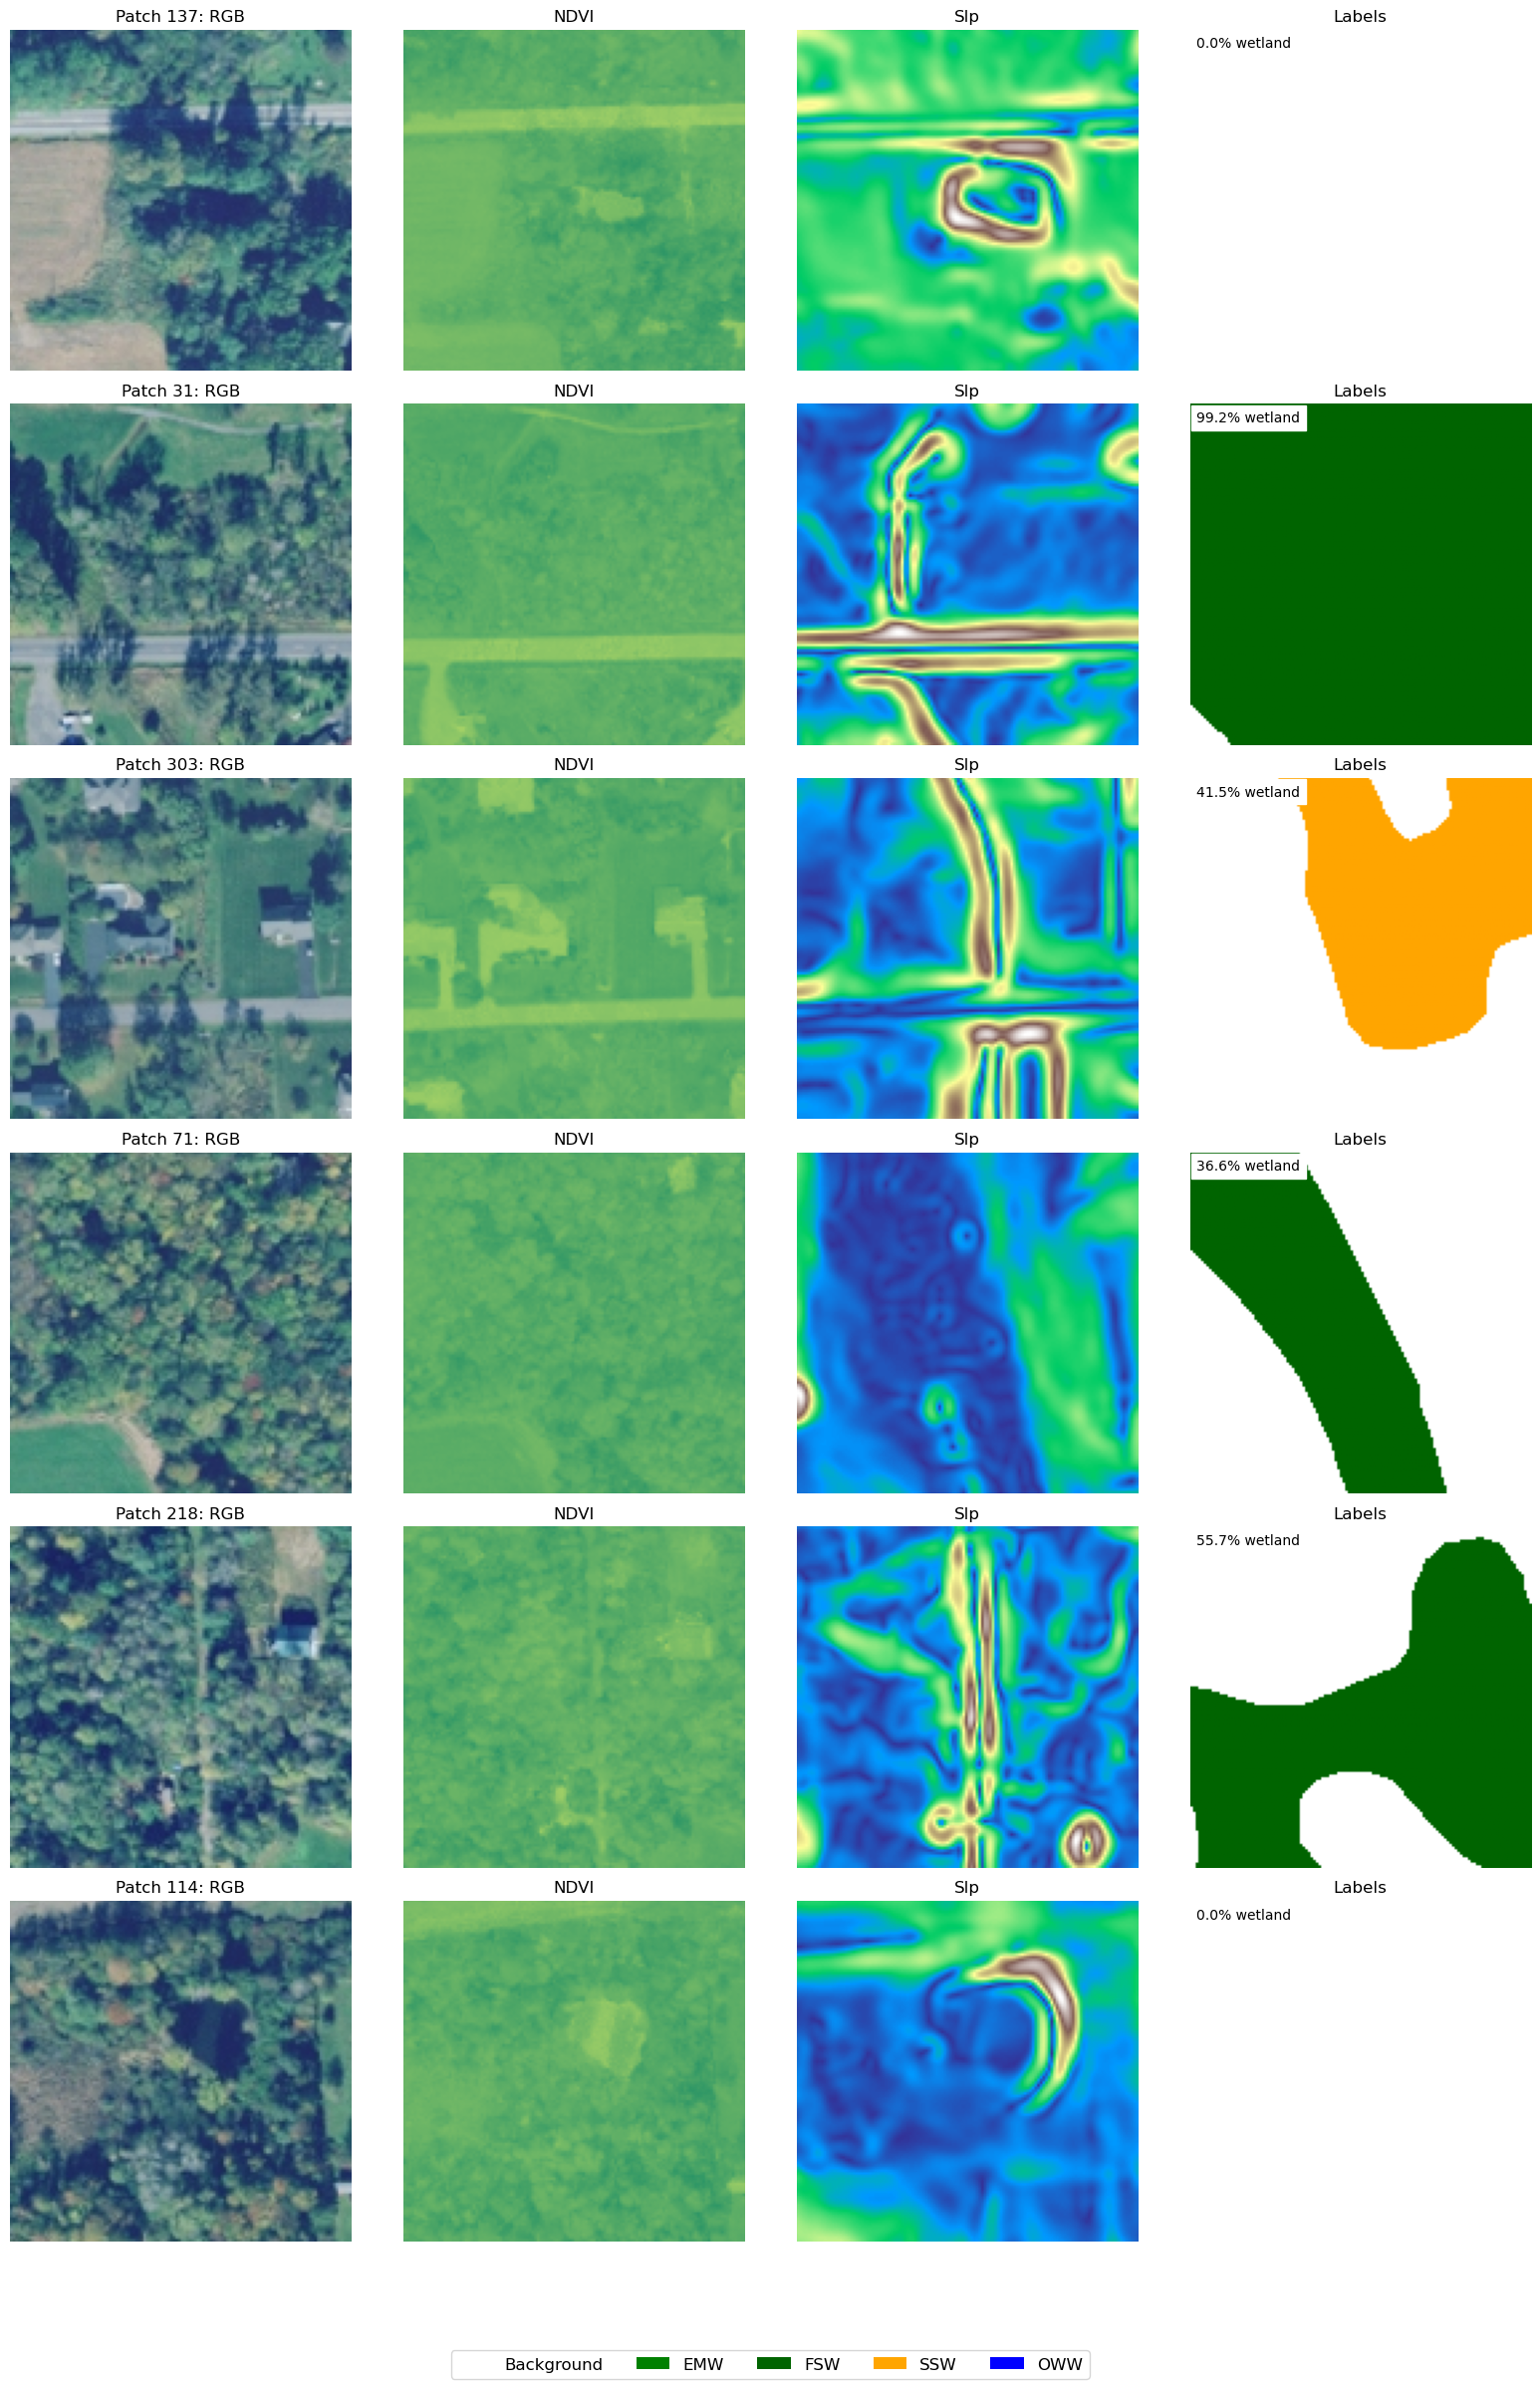

Saved visualization to Data/Patches_v2/patch_samples.png


In [19]:

# === VISUALIZE SAMPLE PATCHES ===
print("\nGenerating patch visualization...")

# Setup
class_names = ['Background', 'EMW', 'FSW', 'SSW', 'OWW']
# class_names = ['Background', 'WET']
colors = ['white', 'green', 'darkgreen', 'orange', 'blue']
# colors = ['white', 'green']
cmap = ListedColormap(colors)

# Select random patches to visualize
np.random.seed(123)
n_samples = 6
sample_indices = np.random.choice(len(wetland_patches_X), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(16, n_samples * 4))

for row, idx in enumerate(sample_indices):
    X_patch = wetland_patches_X[idx]
    y_patch = wetland_patches_y[idx]
    
    # RGB (bands 0, 1, 2) - normalize for display
    rgb = X_patch[0:3].transpose(1, 2, 0)  # (3, H, W) -> (H, W, 3)
    rgb = np.nan_to_num(rgb / 255.0, nan=0)
    
    # NDVI (band 5)
    ndvi = X_patch[5]
    
    # DEM (band 6)
    dem = X_patch[6]

    # Slope (band) 
    slp = X_patch[8]
    
    # Plot RGB
    axes[row, 0].imshow(rgb)
    axes[row, 0].set_title(f"Patch {idx}: RGB")
    axes[row, 0].axis('off')
    
    # Plot NDVI
    axes[row, 1].imshow(ndvi, cmap='summer', vmin=-0.75, vmax=0.75)
    axes[row, 1].set_title("NDVI")
    axes[row, 1].axis('off')
    
    # Plot DEM
    axes[row, 2].imshow(slp, cmap='terrain')
    axes[row, 2].set_title("Slp")
    axes[row, 2].axis('off')
    
    # Plot labels
    im = axes[row, 3].imshow(y_patch, cmap=cmap, vmin=0, vmax=4)
    axes[row, 3].set_title("Labels")
    axes[row, 3].axis('off')
    
    # Count wetland pixels in this patch
    wetland_pixels = np.sum(y_patch > 0)
    total_pixels = y_patch.size
    wetland_pct = (wetland_pixels / total_pixels) * 100
    
    # Add text showing wetland coverage
    axes[row, 3].text(
        0.02, 0.98, f"{wetland_pct:.1f}% wetland",
        transform=axes[row, 3].transAxes,
        fontsize=10, color='black', backgroundcolor='white',
        verticalalignment='top'
    )

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for c, n in zip(colors, class_names)]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.06)
plt.savefig(output_dir / "patch_samples.png", dpi=150)
plt.show()

print(f"Saved visualization to {output_dir / 'patch_samples.png'}")

In [22]:
!jupyter nbconvert --to script Python_Code_Analysis/DL_Implement/NYS_03_create_patches_v2.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove"}'

[NbConvertApp] Converting notebook Python_Code_Analysis/DL_Implement/NYS_03_create_patches_v2.ipynb to script
[NbConvertApp] Writing 973 bytes to Python_Code_Analysis/DL_Implement/NYS_03_create_patches_v2.py
